# UBS Challange

In [2]:
import pandas as pd
import numpy as np
import os

path = os.path.join(os.path.join(os.getcwd(), os.pardir),"data")
print(path)

c:\Users\Usee\Documents\Datathon_24\datathon\src\..\data


In [3]:
file = os.path.join(path, "skylab_instagram_datathon_dataset.csv")
data = pd.read_csv(file, delimiter=";")
print(data.describe())

          followers       pictures         videos      comments         likes
count  5.792580e+05  695803.000000  684349.000000  6.953430e+05  6.959770e+05
mean   1.342432e+07     344.272540      61.244426  3.043246e+04  2.163189e+06
std    1.106975e+08    2777.396873     564.468480  2.766459e+05  1.803193e+07
min    0.000000e+00       0.000000       0.000000  0.000000e+00  0.000000e+00
25%    3.013372e+05      19.000000       2.000000  3.710000e+02  1.727700e+04
50%    1.104144e+06      44.000000       7.000000  1.435000e+03  9.318400e+04
75%    4.479325e+06     122.000000      20.000000  5.872000e+03  4.577470e+05
max    3.502565e+09  141746.000000   35905.000000  1.732046e+07  7.120711e+08


# Explore Companies

number companies:  54


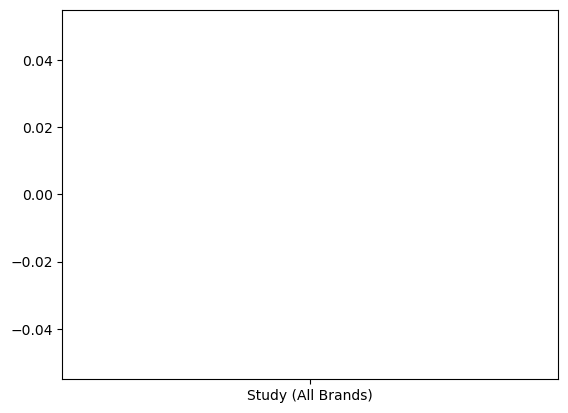

                                     entries   na
Global Luxury Analysts Interest List   29233  NaN
Beauty & Boutique                      44266  NaN
Luxury & Premium & Mainstream          64541  NaN
Apparel Retail                         69341  NaN
US Softlines Analyst Interest List    113744  NaN


In [8]:
import matplotlib.pyplot as plt

def count_entries(data: pd.DataFrame, column: str):
    cats = list(set(list(data["compset"])))
    print("number companies: ", len(cats))

    table = pd.DataFrame(columns=["entries", "na"], index=cats)
    for company in cats:
        data_company = data[data["compset"] == company]
        table.loc[company, "entries"] = len(data_company)
    table = table.sort_values(by=["entries"])
    return table

table = count_entries(data=data, column="compset")
plt.plot(table["na"])
plt.show()
print(table[-5:])

In [42]:
def calculate_yearly_means(df, col, category_column, category_value, period: str="yearly"):
    filtered_df = df[df[category_column] == category_value]
    
    # Convert the index to datetime if it's not already
    if period == "yearly":
        filtered_df["time"] = pd.to_datetime(filtered_df["period_end_date"]).dt.year
    elif period == "montly":
        filtered_df["time"] = pd.to_datetime(filtered_df["period_end_date"]).dt.month

    yearly_means = filtered_df[col].groupby(filtered_df["time"]).mean()
    
    return yearly_means

print(calculate_yearly_means(data, "followers", "compset", "Soft Luxury", period="yearly"))

time
2015    4.352819e+06
2016    8.192623e+06
2017    1.173550e+07
2018    1.491700e+07
2019    1.874780e+07
2020    2.167687e+07
2021    2.375165e+07
2022    2.632273e+07
2023    2.881174e+07
Name: followers, dtype: float64


C:\Users\Usee\AppData\Local\Temp\ipykernel_9540\291521671.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["time"] = pd.to_datetime(filtered_df["period_end_date"]).dt.year


In [64]:
def average_table(df, category_column, interesting_period, period: str="yearly"):
    cols = ["pictures", "videos", "comments", "likes", "followers"] 
    cats = df[category_column].unique()
    table = pd.DataFrame(columns=cols, index=cats)
    
    if period == "yearly":
        df["time"] = pd.to_datetime(df["period_end_date"]).dt.year
    elif period == "monthly":
        df["time"] = pd.to_datetime(df["period_end_date"]).dt.month

    df = df[df["time"] == interesting_period]

    for cat in cats:
        df_cat = df[df[category_column] == cat]
        for col in cols:

            table.loc[cat, col] = np.nanmean(df_cat[col])
     
    return table

table = average_table(data, "legal_entity_name", 2020)
print(table)

C:\Users\Usee\AppData\Local\Temp\ipykernel_9540\2059905629.py:17: RuntimeWarning: Mean of empty slice
  table.loc[cat, col] = np.nanmean(df_cat[col])


                                   pictures      videos      comments  \
Capri Holdings                    35.812937    7.592657  10619.134615   
Restaurant Brands International  442.432692   90.240385  22554.423077   
Pepsi                               56.5625   43.322115   7526.163462   
Monster Energy                    14.461538   36.538462   6581.134615   
Aritzia                           29.634615    5.038462   4381.403846   
...                                     ...         ...           ...   
Yum! Brands                      787.826923  236.980769  44303.346154   
Roborock;Xiaomi                   39.057692    9.884615    481.134615   
Marisa Lojas SA                        44.5    6.980769   9208.730769   
Mizuno Corp                          329.25   57.365385   5211.961538   
Klean Kanteen Inc                169.384615    6.615385   4151.442308   

                                          likes        followers  
Capri Holdings                   2269962.853147  1686595

In [65]:
print(table.isna().sum())
table = table.dropna()

pictures      6
videos        6
comments      6
likes         6
followers    19
dtype: int64


In [60]:
table

,pictures,videos,comments,likes,followers
Soft Luxury,236.531306,21.669946,17613.527728,3104186.263864,21676871.592129
Luxury & Premium & Mainstream,202.669389,24.331138,11003.103267,1455502.682561,10403973.492819
US Softlines Analyst Interest List,767.265249,89.261569,92683.216271,4981743.998272,34128559.779048
Global Luxury Analysts Interest List,211.97669,22.120629,13522.498252,2110255.434732,14886958.242424
Coffee,778.338462,149.107692,84964.230769,2420038.930769,14738673.6
Restaurants,489.842308,118.667308,34445.95,672919.955769,5208781.355769
Beverages,98.10543,109.030763,7528.836306,450241.281015,2431038.545378
Sports drinks,40.067308,18.105769,2585.701923,55213.423077,1056380.932692
Energy drinks,244.557692,617.769231,30937.564103,3180694.5,10124724.134615
Fast Fashion,490.151224,40.553322,147664.770105,4132673.801573,14269102.059207


In [66]:
from sklearn.cluster import KMeans

def apply_kmeans_clustering(df, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    
    kmeans.fit(df)
    
    # Get cluster labels
    cluster_labels = kmeans.labels_
    
    return cluster_labels

print(apply_kmeans_clustering(table, num_clusters=2))

c:\Users\Usee\anaconda3\envs\dt\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Usee\anaconda3\envs\dt\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


c:\Users\Usee\anaconda3\envs\dt\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Usee\anaconda3\envs\dt\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Usee\anaconda3\envs\dt\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Usee\anaconda3\envs\dt\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to 

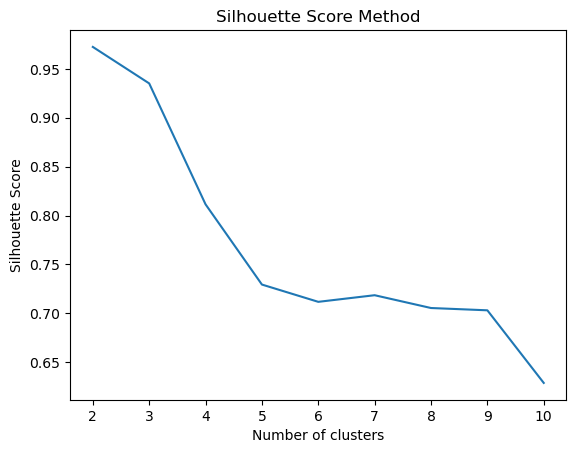

In [69]:
from sklearn.metrics import silhouette_score

def kmeans_silhouette_scores(df):
    silhouette_scores = []

    # Example using the same dataset as above
    for i in range(2, 11):  # Silhouette score cannot be computed with only one cluster
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        score = silhouette_score(df, kmeans.labels_)
        silhouette_scores.append(score)
    return silhouette_scores

silhouette_scores = kmeans_silhouette_scores(table)
# Plotting the results
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

## K means

In the silhouette score plot, one can see how well different amounts of clusters fit our data. 6 seems like a good fit since it looks like a local minimum after a steep drop. This minimizes the mean, while keeping the variance modest.